In [5]:
import os
import platform
from datetime import datetime

import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.python.keras import layers
from tensorflow.python.keras.metrics import Precision, Recall, BinaryAccuracy

from modules.dataset_utils import DatasetUtils

#######################################################################################################################
# PARÁMETROS DEFINIDOS EN FUNCIÓN DEL USUARIO
#######################################################################################################################

# Ruta hacia los CSV del dataset
train_file_relative = './data/700Train.csv'
validation_file_relative = './data/700Validation.csv'
test_file_relative = './data/700Test.csv'

# Ruta al directorio de imágenes con máscara aplicada
masked_dir_relative = '../local/output_edited'

model_dir_relative = "./models"

# Ruta relativa hacia la librería ai4eutils
ai4eutils_relative = "./repos/ai4eutils"

# Ruta relativa hacia la librería CameraTraps
CameraTraps_relative = "./repos/CameraTraps"

#######################################################################################################################
# PARÁMETROS PARA CNN
#######################################################################################################################

IMG_HEIGHT = IMG_WIDTH = 500
EPOCHS = 15
BATCH_SIZE = 16

#######################################################################################################################
#######################################################################################################################

home = os.path.expanduser("~")

ai4utils = os.path.abspath(ai4eutils_relative)
CameraTraps = os.path.abspath(CameraTraps_relative)
train_file = os.path.abspath(train_file_relative)
validation_file = os.path.abspath(validation_file_relative)
test_file = os.path.abspath(test_file_relative)
masked_dir = os.path.abspath(masked_dir_relative)
model_dir = os.path.abspath(model_dir_relative)

try:
    os.environ['PYTHONPATH']
except KeyError:
    os.environ['PYTHONPATH'] = ""
if platform.system() == 'Windows':
    os.environ['PYTHONPATH'] += (";" + ai4utils)
    os.environ['PYTHONPATH'] += (";" + CameraTraps)
else:
    os.environ['PYTHONPATH'] += (":" + ai4utils)
    os.environ['PYTHONPATH'] += (":" + CameraTraps)

print('==============================================================================================================')
print('PYTHONPATH: ' + os.environ['PYTHONPATH'])
print('')
print('ai4eutils PATH: ' + '\t\t' + ai4utils)
print('CameraTraps PATH: ' + '\t\t' + CameraTraps)
print('Train CSV PATH: ' + '\t\t' + train_file)
print('Validation CSV PATH: ' + '\t' + validation_file)
print('Test CSV PATH: ' + '\t\t\t' + test_file)
print('masked PATH: ' + '\t\t\t' + masked_dir)
print('models PATH: ' + '\t\t\t' + model_dir)
print('==============================================================================================================')

PYTHONPATH: /Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo:/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/ai4eutils:/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/CameraTraps:/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/ai4eutils:/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/CameraTraps

ai4eutils PATH: 		/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/ai4eutils
CameraTraps PATH: 		/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/CameraTraps
Train CSV PATH: 		/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/data/700Train.csv
Validation CSV PATH: 	/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/data/700Validation.csv
Test CSV PATH: 			/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/data/700Test.csv
masked PATH: 			/Users/carlos/WORKSPACE/local/output_edited
models PATH: 			/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/models


In [6]:
custom = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
)

general = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

file_names, labels = DatasetUtils.load_dataset(train_file, masked_dir)
d = {'file_names': file_names, 'labels': labels}
train_df = pd.DataFrame(data=d, dtype=str)
train_dataset = custom.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col="file_names",
    y_col="labels",
    class_mode='binary',
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)
from collections import Counter
itemCt = Counter(train_dataset.classes)
maxCt = float(max(itemCt.values()))
cw = {clsID : maxCt/numImg for clsID, numImg in itemCt.items()}

file_names, labels = DatasetUtils.load_dataset(validation_file, masked_dir)
d = {'file_names': file_names, 'labels': labels}
validation_df = pd.DataFrame(data=d, dtype=str)
validation_dataset = general.flow_from_dataframe(
    dataframe=validation_df,
    x_col="file_names",
    y_col="labels",
    class_mode='binary',
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)

file_names, labels = DatasetUtils.load_dataset(test_file, masked_dir)
d = {'file_names': file_names, 'labels': labels}
test_df = pd.DataFrame(data=d, dtype=str)
test_dataset = general.flow_from_dataframe(
    dataframe=test_df,
    x_col="file_names",
    y_col="labels",
    class_mode='binary',
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)

Found 1450 validated image filenames belonging to 2 classes.
Found 312 validated image filenames belonging to 2 classes.
Found 311 validated image filenames belonging to 2 classes.


In [7]:
model = keras.Sequential([

    layers.Conv2D(16, kernel_size=3, padding='same', activation=tf.nn.relu, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(32, kernel_size=3, padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, kernel_size=3, padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(32, kernel_size=3, padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(16, kernel_size=3, padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(2, 2),

    # Full connected
    layers.Flatten(),
    layers.Dense(1024, kernel_regularizer=keras.regularizers.l2(1e-3), activation=tf.nn.relu),
    layers.Dropout(0.5),
    layers.Dense(1024, kernel_regularizer=keras.regularizers.l2(1e-3), activation=tf.nn.relu),
    layers.Dropout(0.5),

    # Capa de salida
    layers.Dense(1, activation=tf.nn.sigmoid)
])

In [8]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=[keras.losses.BinaryCrossentropy()],
              metrics=['accuracy'])

In [9]:
hist = model.fit(train_dataset, class_weight=cw, epochs=EPOCHS, validation_data=validation_dataset, batch_size=BATCH_SIZE)

Epoch 1/15


2022-10-19 11:07:19.353693: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-19 11:07:19.730038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - ETA: 0s - loss: 0.7893 - accuracy: 0.8676

2022-10-19 11:07:41.799776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - 24s 259ms/step - loss: 0.7893 - accuracy: 0.8676 - val_loss: 0.4743 - val_accuracy: 0.8269
Epoch 2/15
91/91 [==============================] - 23s 254ms/step - loss: 0.5752 - accuracy: 0.8524 - val_loss: 0.3650 - val_accuracy: 0.8878
Epoch 3/15
91/91 [==============================] - 23s 255ms/step - loss: 0.5190 - accuracy: 0.8828 - val_loss: 0.2972 - val_accuracy: 0.9135
Epoch 4/15
91/91 [==============================] - 23s 248ms/step - loss: 0.5189 - accuracy: 0.8876 - val_loss: 0.3126 - val_accuracy: 0.9135
Epoch 5/15
91/91 [==============================] - 23s 251ms/step - loss: 0.4805 - accuracy: 0.8897 - val_loss: 0.3034 - val_accuracy: 0.9167
Epoch 6/15
91/91 [==============================] - 23s 254ms/step - loss: 0.4888 - accuracy: 0.8924 - val_loss: 0.3490 - val_accuracy: 0.9071
Epoch 7/15
91/91 [==============================] - 23s 250ms/step - loss: 0.4652 - accuracy: 0.8966 - val_loss: 0.3158 - val_accuracy: 0.9103
Epoch 8/15

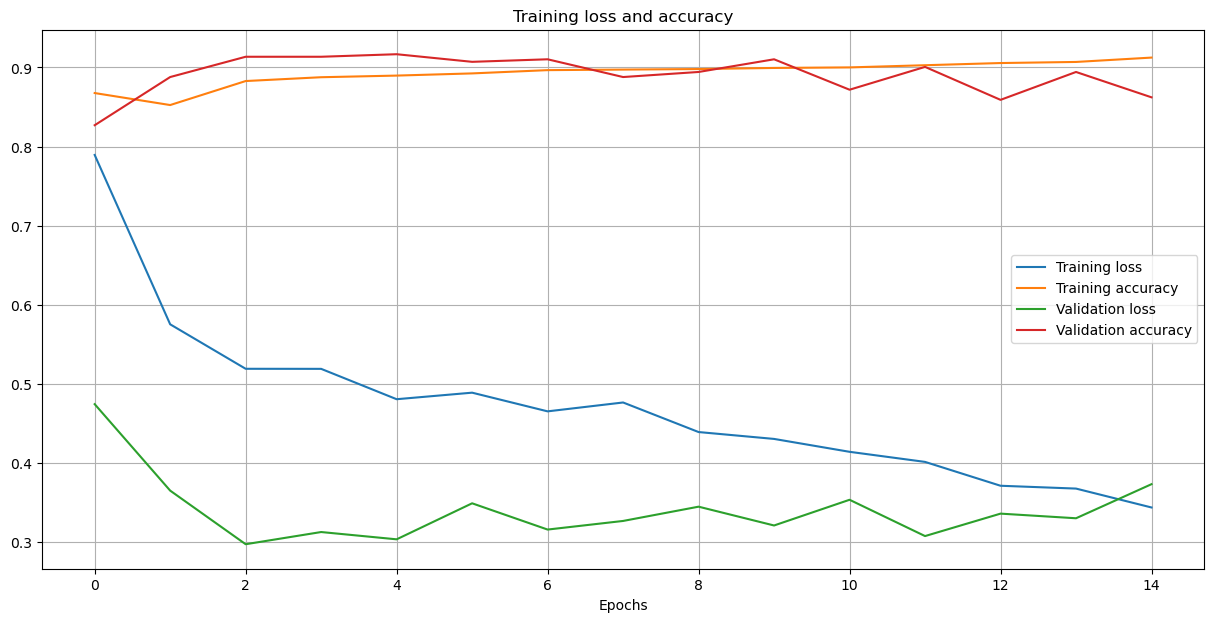

In [10]:
ax = pd.DataFrame(data=hist.history).plot(figsize=(15, 7))
ax.grid()
_ = ax.set(title="Training loss and accuracy", xlabel="Epochs")
_ = ax.legend(["Training loss", "Training accuracy", "Validation loss", "Validation accuracy"])

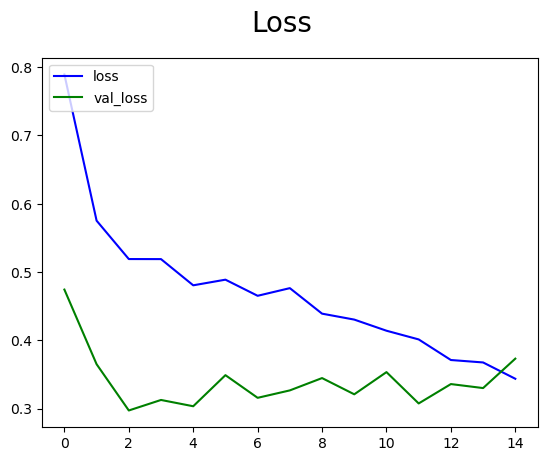

In [11]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='blue', label='loss', )
plt.plot(hist.history['val_loss'], color='green', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

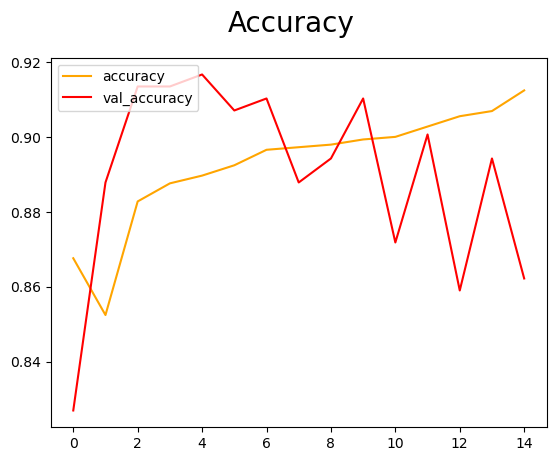

In [12]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='orange', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='red', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [13]:
results = model.evaluate(test_dataset, verbose=1)

20/20 [==============================] - 2s 80ms/step - loss: 0.3828 - accuracy: 0.8457


In [14]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for sample in test_dataset:
    X = sample[0]
    y = sample[1]
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
print('Precision: ' + str(pre.result()))
print('Recall: ' + str(re.result()))
print('BinaryAccuracy: ' + str(acc.result()))

1/1 [==============================] - 0s 93ms/step


2022-10-19 11:13:04.491336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 19ms/step


KeyboardInterrupt: 

In [ ]:
date = datetime.utcnow().strftime('%Y-%m-%d_%H-%M')
if platform.system() == 'Windows':
    path = model_dir + '\\' + date
else:
    path = model_dir + '/' + date

model.save(path)